# Spec2Vec - test ability to match unkown spectra to similar ones

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

In [25]:
import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [3]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Get metadata from benchmarking subset

In [5]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = []

_,_,_,_, spectra_metadata_uniqueinchikey_positive = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [11]:
benchmarking_gnpsIDs = spectra_metadata_uniqueinchikey_positive['gnps_ID'].values.copy()
benchmarking_gnpsIDs.shape

(10998,)

In [12]:
benchmarking_gnpsIDs[:10]

array(['CCMSLIB00005435506', 'CCMSLIB00005435507', 'CCMSLIB00005435517',
       'CCMSLIB00005435523', 'CCMSLIB00005435528', 'CCMSLIB00005435529',
       'CCMSLIB00005435532', 'CCMSLIB00005435537', 'CCMSLIB00005435545',
       'CCMSLIB00005435547'], dtype=object)

### Shuffle gnps IDs

In [13]:
np.random.seed(42) # to make it reproducible
np.random.shuffle(benchmarking_gnpsIDs)

In [14]:
benchmarking_gnpsIDs[:10]

array(['CCMSLIB00000579646', 'CCMSLIB00000850303', 'CCMSLIB00000856170',
       'CCMSLIB00000845612', 'CCMSLIB00000079847', 'CCMSLIB00000845821',
       'CCMSLIB00000079739', 'CCMSLIB00000854639', 'CCMSLIB00000846422',
       'CCMSLIB00000205344'], dtype=object)

In [15]:
all_gnpsIDs = spectra_metadata['gnps_ID'].values
all_gnpsIDs.shape

(90226,)

In [16]:
remove_parts = [0, 250, 500, 1000, 2000, 5000, 10998]

for i, remove_part in enumerate(remove_parts):
    print("Run", i, 20 * '--')
    # Remove some benchmarking spectra from corpus
    MS_documents_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if all_gnpsIDs[x] not in benchmarking_gnpsIDs[:remove_part]]   
    print("Modified corpus consists of", len(MS_documents_removedpart), "documents.")
    
    MS_measure = SimilarityMeasures(MS_documents_removedpart)
    MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
    print("Number of unique words: ", len(MS_measure.dictionary))
    
    # Train new model based on reduced corpus
    file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_removed' + str(remove_part) + '_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
    MS_measure.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                                 min_count=1, workers=4, iterations= [10,5], 
                                 use_stored_model=True)
    print("Learning rate droped from", MS_measure.model_word2vec.alpha, "to", MS_measure.model_word2vec.min_alpha_yet_reached)
    

Run 0 ----------------------------------------
Modified corpus consists of 90226 documents.
Preprocess documents...
Number of unique words:  145584
No saved word2vec model found with given filename!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 7042434.0
 Epoch 2 of 15.Change in loss after epoch 2: 5072664.0
 Epoch 3 of 15.Change in loss after epoch 3: 4562966.0
 Epoch 4 of 15.Change in loss after epoch 4: 3656586.0
 Epoch 5 of 15.Change in loss after epoch 5: 3622282.0
 Epoch 6 of 15.Change in loss after epoch 6: 3383436.0
 Epoch 7 of 15.Change in loss after epoch 7: 3347842.0
 Epoch 8 of 15.Change in loss after epoch 8: 3019338.0
 Epoch 9 of 15.Change in loss after epoch 9: 1972052.0
 Epoch 10 of 15.Change in loss after epoch 10: 1846808.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_removed0_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Chan

 Epoch 8 of 15.Change in loss after epoch 8: 2841286.0
 Epoch 9 of 15.Change in loss after epoch 9: 2723382.0
 Epoch 10 of 15.Change in loss after epoch 10: 1657664.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_removed5000_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1632552.0
 Epoch 12 of 15.Change in loss after epoch 12: 1599740.0
 Epoch 13 of 15.Change in loss after epoch 13: 1594932.0
 Epoch 14 of 15.Change in loss after epoch 14: 1554652.0
 Epoch 15 of 15.Change in loss after epoch 15: 1538556.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_removed5000_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model
Learning rate droped from 0.025 to 0.021250662943233287
Run 6 ----------------------------------------
Modified corpus consists of 79228 documents.
Prep

In [28]:
def get_similarities_removed_parts(A_ref, 
                                   remove_parts, 
                                   filenames, 
                                   save_matrix, 
                                   save_refscore):
    # Run routine for all saved models
    ref_score_Spec2Vec_tests_lst = []
    for i, filename in enumerate(filenames):
        print("Run", i, 20 * '--')
        MS_measure.build_model_word2vec(filename, size=300, window=500, 
                                 min_count=1, workers=4, iterations=1, 
                                 use_stored_model=True)

        MS_measure.get_vectors_centroid(method = 'ignore', #'update',
                                 extra_weights = MS_documents_intensity, 
                                 tfidf_weighted = False,
                                 weight_method = 'sqrt', 
                                 tfidf_model = None,
                                 extra_epochs = 5)

        M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')
        np.save(save_matrix + str(remove_parts[i]) + '_191120.npy', M_sim_ctr)

        A = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
        A = np.delete(A.reshape(length**2), remove_diagonal)

        # Plot against dice score on morgan3 fingerprints   
        ref_score_Spec2Vec = plot_precentile(A, A_ref, num_bins = 1000 , show_top_percentile = 0.5)
        ref_score_Spec2Vec_tests_lst.append(ref_score_Spec2Vec)
        np.save(save_refscore + str(remove_parts[i]) + '_morgan3_dice.npy', ref_score_Spec2Vec) 
        
    return ref_score_Spec2Vec_tests_lst

### Import benchmarking subset (uniqueInchikey_positive dataset)

In [18]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_uniqueInchikey_191107.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [19]:
MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


### Import reference similarity scores (based on molecular fingerprints)

In [20]:
filename = PATH_COMPUTED + 'MS_sim_mol_uniqueInchikey_morgan3_dice2048_191119.npy'
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

Molecular similarity scores found and loaded.


In [21]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [23]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
A_ref = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = A_ref.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
A_ref = np.delete(A_ref.reshape(length**2), remove_diagonal)

### Import reference score (modified cosine)

In [24]:
ref_score_cum_modcos_minmatch14 = np.load(PATH_COMPUTED + 'spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy')

Load stored word2vec model ...
All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents. 10998  documents.520  of  10998  documents. Calculated centroid vectors for  570  of  10998  documents. 10998  documents.10998  documents.  documents. documents. 10998  documents.  documents. 10998  documents. 10998  documents. of  10998  documents.5470  of  10998  documents. documents. of  10998  documents.6400  of  10998  documents. 10998  documents. 10998  documents.  of  10998  documents.  documents.10998  documents. 10998  documents.  of  10998  documents.Load stored word2vec model ...
Not all 'words' of the given documents are present in the trained word2vec model!
1  out of  116344  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
  Calculated centroid vectors for  10998  of  10998  docume

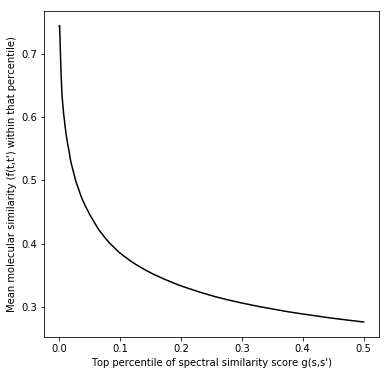

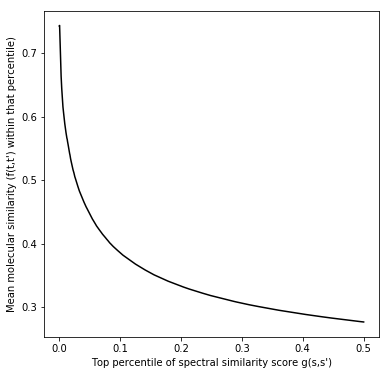

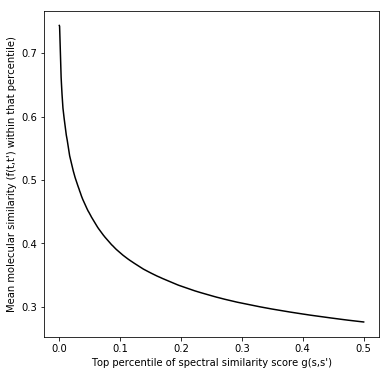

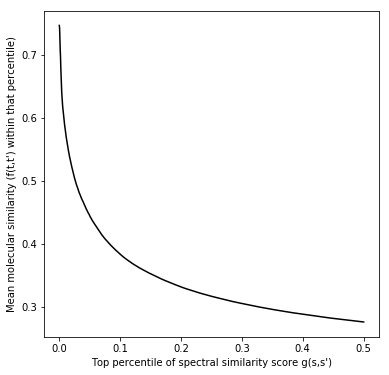

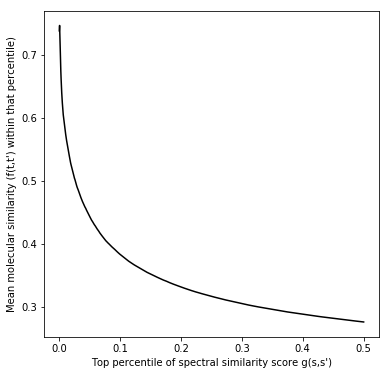

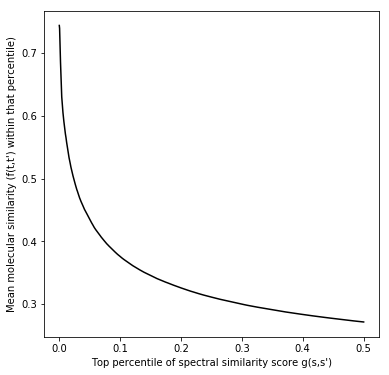

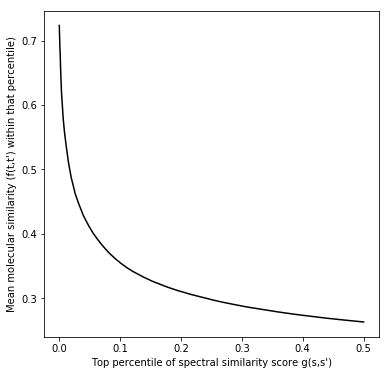

In [29]:
remove_parts = [0, 250, 500, 1000, 2000, 5000, 10998]

filenames = []
for remove_part in remove_parts:   
    # Load model trained on reduced corpus
    filenames.append(PATH_SAVE_MODEL + 'S2V_allGNPS_pos_removed' + str(remove_part) + '_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model')
    
ref_score_Spec2Vec_tests_lst = get_similarities_removed_parts(A_ref,
                                        remove_parts,
                                        filenames, 
                                        save_matrix = PATH_COMPUTED + 'M_sim_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_10_removed', 
                                        save_refscore = PATH_COMPUTED + 'ref_score_allGNPS_pos_d300_w500_minmax10_1000_dec2_exp08_iter_10_removed')        
    

## Plot results

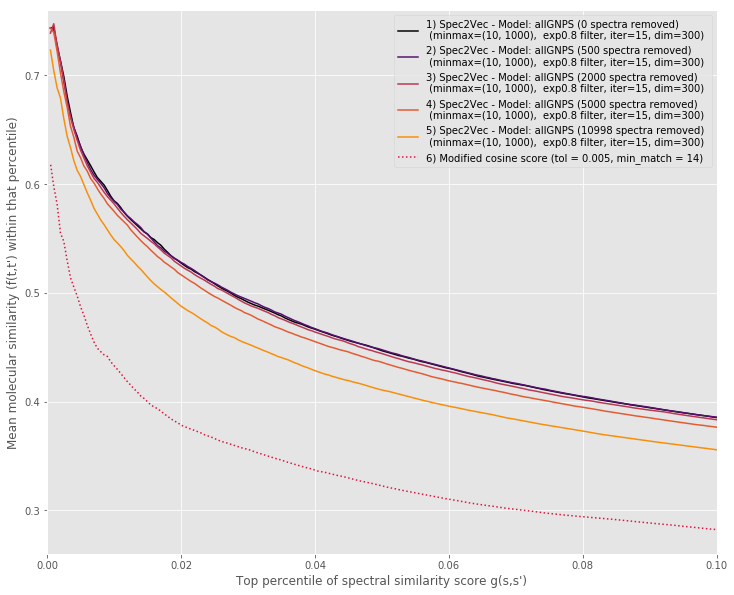

In [41]:
from matplotlib import pyplot as plt
import matplotlib

# Compare all:
num_bins = 1000
show_top_percentile = 0.5

plt.style.use('ggplot') # ('default')
fig, ax = plt.subplots(figsize=(12,10))
cmap = matplotlib.cm.get_cmap('inferno') #'viridis') 

selectedpairs = [(x, remove_parts[x]) for x in [0,2,4,5,6]] #range(len(remove_parts))]
count = 1

for i, remove_part in selectedpairs:
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_tests_lst[i], 
             color= cmap(i/8), 
             label= str(count) + ') Spec2Vec - Model: allGNPS (' + str(remove_part) + ' spectra removed) \n (minmax=(10, 1000),  exp0.8 filter, iter=15, dim=300)')
    count += 1

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum_modcos_minmatch14, 
         ':', color='crimson', #'gold', #'crimson',
         label= str(count) + ') Modified cosine score (tol = 0.005, min_match = 14)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.26, 0.76)
plt.savefig(PATH_OUTPUT + 'Top_percentile_testing_removing_spectra_191120.pdf')

## Note:
### Issue with repdroducibility was: Gensim has a weird learning-rate decay!  
In gensim the default learning-rate (alpha) is set to 0.025 and it will linearly decay to a default of min_alpha = 0.0001.
This is independent of the number of epochs (iter), which lead to unexpected results!
A model trained on 10 iterations only will look very different than a model after 10 iterations which was started with iter=100. 